<a href="https://colab.research.google.com/github/thunderstruck/climbicus/blob/liucija%2Fcastle-cafe-grades/model_training/train_model_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Define callbacks


In [1]:
import io
import itertools
import os
import time

import numpy as np
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import skimage
import tensorflow as tf
from keras.callbacks import Callback, CSVLogger, EarlyStopping, LambdaCallback, ModelCheckpoint, TensorBoard, LearningRateScheduler

logs_base_dir = "callbacks"


def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image


def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    return figure


def log_confusion_matrix(epoch, logs, model, validation_generator, log_dir):
    # Use the model to predict the values from the validation dataset.
    y_pred_raw = model.predict_generator(
        validation_generator, validation_generator.samples // validation_generator.batch_size
    )
    y_pred = np.argmax(y_pred_raw, axis=1)
    cm = confusion_matrix(validation_generator.classes, y_pred)
    # Calculate the confusion matrix.
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=list(validation_generator.class_indices.keys()))
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    cm_dir = os.path.join(log_dir, "cm")
    file_writer_cm = tf.summary.create_file_writer(cm_dir)
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)


class LRTensorBoard(TensorBoard):
    def __init__(self, log_dir, **kwargs):
        super().__init__(log_dir=log_dir, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({"lr": tf.keras.backend.eval(self.model.optimizer.lr)})  # Store learning rate as lr in the event folder
        super().on_epoch_end(epoch, logs)


class TensorBoardImage(Callback):
    def __init__(self, tag, log_dir):
        super().__init__()
        self.tag = tag
        self.log_dir = log_dir

    def on_epoch_end(self, epoch, logs={}):
        # Load image
        img = skimage.data.astronaut()
        # Do something to the image
        img = (255 * skimage.util.random_noise(img)).astype("uint8")

        td_dir = os.path.join(self.log_dir, "td")
        writer = tf.summary.create_file_writer(td_dir)
        with writer.as_default():
            img = np.reshape(img, (-1, 512, 512, 3))
            tf.summary.image("Training data", img, step=epoch)


def exponential_decay(lr0, s):
  def exponential_decay_fn(epoch):
    return lr0 * 0.1 ** (epoch/s)
  return exponential_decay_fn


def get_callbacks(model_name, model, train_generator, validation_generator):
    model_id = time.strftime("%Y-%m-%d_%H-%M-%S")
    callback_csv = CSVLogger(
        filename=os.path.join(logs_base_dir, f"{model_name}_{model_id}.csv"), separator=",", append=False
    )
    os.makedirs(os.path.join(logs_base_dir, "models"), exist_ok=True)
    callback_model = ModelCheckpoint(
        filepath=os.path.join(logs_base_dir, "models", f"{model_name}_{model_id}.hdf5"),
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
        period=3,
    )
    tensorboard_log_dir = os.path.join(logs_base_dir, "logs", f"{model_name}_{model_id}")
    callback_tensorboard = TensorBoard(
        log_dir=tensorboard_log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=True,
        batch_size=train_generator.samples / train_generator.batch_size,
        write_images=True,
    )
    callback_learning_rate = LRTensorBoard(log_dir=os.path.join(logs_base_dir, 'logs', f'{model_name}_{model_id}'))

    callback_early_stopping = EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=10)
    tbi_callback = TensorBoardImage("Example image", tensorboard_log_dir)
    cm_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: log_confusion_matrix(
            epoch, logs, model, validation_generator, tensorboard_log_dir
        )
    )

    exponential_decay_fn = exponential_decay(lr0=0.0001, s=200)
    lr_scheduler = LearningRateScheduler(exponential_decay_fn)

    return [
#         callback_csv,
        callback_model,
        callback_tensorboard,
        # callback_learning_rate,
        callback_early_stopping,
        # tbi_callback,
#         cm_callback,
        lr_scheduler,
    ]


Using TensorFlow backend.


#### Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -a 'drive/My Drive/LiuAnd/climbicus/callbacks/.' /content/callbacks/

In [0]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.utils.class_weight import compute_class_weight

In [0]:
from keras.applications import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.models import load_model
from tensorboard import notebook
from keras.metrics import top_k_categorical_accuracy

In [0]:
from keras import models
from keras import layers
from keras import optimizers

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

#### Setup

In [0]:
def save_class_indices(generator, filename):
    class_indices_opp = {v:k for k, v in generator.class_indices.items()}
    
    def save_obj(obj, name ):
        with open(name + '.pkl', 'wb') as f:
            pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
    save_obj(class_indices_opp, filename)
    return generator.class_indices, class_indices_opp

In [0]:
def get_training_directories(base_dir):
    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'val')
    test_dir = os.path.join(base_dir, 'test')
    return train_dir, validation_dir, test_dir

In [0]:
base_dir = 'drive/My Drive/LiuAnd/climbicus/categories_castle_cafe/categories_castle_cafe_categories_blurred_photos_removed/'
# base_dir = 'drive/My Drive/LiuAnd/climbicus/categories_castle_cafe/categories_castle_cafe_categories_2_photos/'
no_cats = 47

In [0]:
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from keras.applications.inception_v3 import preprocess_input as preprocess_input_inception
from keras.applications.xception import preprocess_input as preprocess_input_xception

def get_cnn_data_generators(cnn):
    if cnn == 'vgg16':
      pre_processor = preprocess_input_vgg16
    elif cnn == 'inception':
      pre_processor = preprocess_input_inception
    elif cnn == 'xception':
      pre_processor = preprocess_input_xception
    else:
      raise ValueError(f'Unknown pre-trained CNN. Got {cnn} whereas vgg16, inception or exception is expected.')

    train_datagen = ImageDataGenerator(
        preprocessing_function=pre_processor,
        # brightness_range=(0.003, 1.6),
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    test_datagen = ImageDataGenerator(preprocessing_function=pre_processor)
    return train_datagen, test_datagen
    

In [0]:
def get_image_batches(train_datagen, test_datagen, batch_size, cnn):
    # Different pre-trained CNN's use different target images sizes as input 
    if cnn == 'vgg16':
      target_size = (224, 224)  # All images will be resized to 224x224
    elif cnn == 'inception':
      target_size = (299, 299)  # All images will be resized to 299x99
    elif cnn == 'xception':
      target_size = (299, 299)  # All images will be resized to 299x299
    else:
      raise ValueError(f'Unknown pre-trained CNN. Got {cnn} whereas vgg16, inception or exception is expected.') 
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        # save_to_dir='train_samples'
        )

    validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        # save_to_dir='val_samples'
        )
    
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        )
    
    return train_generator, validation_generator, test_generator

In [0]:
def get_conv_base(cnn):
    if cnn == 'vgg16':
        conv_base = VGG16(weights='imagenet',
                           include_top=False,
                           input_shape=(224, 224, 3))
    elif cnn == 'inception':
        conv_base = InceptionV3(weights='imagenet',
                                 include_top=False,
                                 input_shape=(299, 299, 3))
    elif cnn == 'xception':
        conv_base = Xception(weights='imagenet',
                             include_top=False,
                             input_shape=(299, 299, 3))
    else:
        raise ValueError(f'Unknown pre-trained CNN. Got {cnn} whereas vgg16, inception or exception is expected.')
    
    return conv_base

In [0]:
def get_cnn_model(pretrained_cnn, no_cats):
    conv_base = get_conv_base(pretrained_cnn)
    conv_base.trainable = False
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(Dense(no_cats, activation='softmax'))

    print(model.summary())
    print(len(model.trainable_weights))
    return model

In [0]:
def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3) 

In [0]:
def top_2_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2) 

In [0]:
def build_compile_cnn(cnn, no_cats):
    model = get_cnn_model(cnn, no_cats)
    model.compile(optimizer=optimizers.RMSprop(),
                  loss='categorical_crossentropy',
                  metrics=['acc', top_2_categorical_accuracy, top_3_categorical_accuracy])
    return model

#### TensorBoard

In [34]:
%reload_ext tensorboard
%tensorboard --logdir 'callbacks/logs/'

Reusing TensorBoard on port 6006 (pid 1286), started 0:00:09 ago. (Use '!kill 1286' to kill it.)

#### Model training

Complete the first 3 steps:

    1) Add your custom network on top of an already trained base network.
    2) Freeze the base network.
    3) Train the part you added.

In [0]:
del model

In [18]:
pre_trained_cnn = 'vgg16'  # 'vgg16', 'inception' or 'xception'
BATCH_SIZE = 14 # trade off between speed of training and accuracy of the weights
EPOCHS = 100
model_name = 'unknown_class'

train_dir, validation_dir, test_dir = get_training_directories(base_dir)

train_datagen, test_datagen = get_cnn_data_generators(cnn=pre_trained_cnn)

train_generator, validation_generator, test_generator = get_image_batches(train_datagen, test_datagen, BATCH_SIZE, cnn=pre_trained_cnn)

val_class_indicies, val_class_indicies_opp = save_class_indices(validation_generator, 'class_indices_cafe')

model = build_compile_cnn(pre_trained_cnn, no_cats)

callbacks = get_callbacks(f'{pre_trained_cnn}_{model_name}', model, train_generator, validation_generator)

class_weights = compute_class_weight('balanced', 
                                     np.unique(train_generator.classes), 
                                     train_generator.classes)

history = model.fit_generator(train_generator,
                              steps_per_epoch=math.ceil(train_generator.samples/train_generator.batch_size),
                              epochs=EPOCHS,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks=callbacks,
                              class_weight=class_weights
                             )

Found 198 images belonging to 47 classes.
Found 162 images belonging to 47 classes.
Found 19 images belonging to 46 classes.




58892288/58889256 [==============================] - 2s 0us/step







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
de

In [0]:
!cp -r /content/callbacks/ 'drive/My Drive/LiuAnd/climbicus/'

#### Load a model

In [0]:
del model

In [0]:
model_name = 'vgg16_0.0001lr0_200s_0.3drop_class_weight_2020-01-12_10-35-29.hdf5'

In [0]:
model = build_compile_cnn('vgg16', no_cats)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 46)                11822     
Total params: 21,149,294
Trainable params: 6,434,606
Non-trainable params: 14,714,688
_________________________________________________________________
None
4


In [0]:
model.load_weights(os.path.join('callbacks/models', model_name))

#### Fine tuning

Steps: 4-5

    4) Unfreeze some layers in the base network.
    5) Jointly train both these layers and the part you added.

In [0]:
len(model.trainable_weights)

4

If loaded in 

In [0]:
[(l.name, l.trainable) for l in model.get_layer("vgg16")._layers]

[('input_7', False),
 ('block1_conv1', True),
 ('block1_conv2', True),
 ('block1_pool', True),
 ('block2_conv1', True),
 ('block2_conv2', True),
 ('block2_pool', True),
 ('block3_conv1', True),
 ('block3_conv2', True),
 ('block3_conv3', True),
 ('block3_pool', True),
 ('block4_conv1', True),
 ('block4_conv2', True),
 ('block4_conv3', True),
 ('block4_pool', True),
 ('block5_conv1', True),
 ('block5_conv2', True),
 ('block5_conv3', True),
 ('block5_pool', True)]

In [0]:
set_trainable = False
for layer in model.get_layer("vgg16")._layers:
    layer.trainable = False
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
[(l.name, l.trainable) for l in model.get_layer("vgg16")._layers]

[('input_7', False),
 ('block1_conv1', False),
 ('block1_conv2', False),
 ('block1_pool', False),
 ('block2_conv1', False),
 ('block2_conv2', False),
 ('block2_pool', False),
 ('block3_conv1', False),
 ('block3_conv2', False),
 ('block3_conv3', False),
 ('block3_pool', False),
 ('block4_conv1', False),
 ('block4_conv2', False),
 ('block4_conv3', False),
 ('block4_pool', False),
 ('block5_conv1', True),
 ('block5_conv2', True),
 ('block5_conv3', True),
 ('block5_pool', True)]

In [0]:
len(model.trainable_weights)  # not sure why this is still 4

4

If using conv_base:

In [0]:
# conv_base.trainable = True

In [0]:
# set_trainable = False
# for layer in conv_base.layers:
#     if layer.name == 'block5_conv1':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

In [0]:
# len(model.trainable_weights)

In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [0]:
ft_model_name = model_name.split('.hdf5')[0] + '_fine_tuned'
EPOCHS=70
callbacks = get_callbacks(f'{pre_trained_cnn}_{ft_model_name}', model, train_generator, validation_generator)

class_weights = compute_class_weight('balanced', 
                                     np.unique(train_generator.classes), 
                                     train_generator.classes)

history = model.fit_generator(train_generator,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    callbacks=callbacks,
                    class_weight=class_weights
                    )

Epoch 1/70
12/12 [==============================] - 4s 312ms/step - loss: 1.9198 - acc: 0.7903 - top_2_categorical_accuracy: 0.8502 - top_3_categorical_accuracy: 0.8862 - val_loss: 1.2137 - val_acc: 0.8903 - val_top_2_categorical_accuracy: 0.9161 - val_top_3_categorical_accuracy: 0.9290
Epoch 2/70
12/12 [==============================] - 3s 223ms/step - loss: 1.3726 - acc: 0.8502 - top_2_categorical_accuracy: 0.8982 - top_3_categorical_accuracy: 0.9281 - val_loss: 1.5249 - val_acc: 0.8581 - val_top_2_categorical_accuracy: 0.9161 - val_top_3_categorical_accuracy: 0.9290
Epoch 3/70
12/12 [==============================] - 3s 230ms/step - loss: 2.8250 - acc: 0.6710 - top_2_categorical_accuracy: 0.8502 - top_3_categorical_accuracy: 0.9221 - val_loss: 1.2268 - val_acc: 0.8839 - val_top_2_categorical_accuracy: 0.9097 - val_top_3_categorical_accuracy: 0.9355

Epoch 00003: val_loss improved from inf to 1.22683, saving model to callbacks/models/vgg16_vgg16_0.0001lr0_200s_0.3drop_class_weight_20

#### Test dataset

Load the model and weights if not trained

In [0]:
model.evaluate_generator(validation_generator)

[1.1166767047439723,
 0.8967741943174793,
 0.9225806443921981,
 0.9225806443921981]

In [0]:
model.evaluate_generator(test_generator)

[2.3536469183470072,
 0.6842105451383089,
 0.8421052725691545,
 0.8421052725691545]

#### Reload validation_generator

In [27]:
pre_trained_cnn = 'vgg16'  # 'vgg16', 'inception' or 'xception'
BATCH_SIZE = 14 # trade off between speed of training and accuracy of the weights
EPOCHS = 100
model_name = ''

train_dir, validation_dir, test_dir = get_training_directories(base_dir)

train_datagen, test_datagen = get_cnn_data_generators(cnn=pre_trained_cnn)

train_generator, validation_generator, test_generator = get_image_batches(train_datagen, test_datagen, BATCH_SIZE, cnn=pre_trained_cnn)


Found 198 images belonging to 47 classes.
Found 165 images belonging to 47 classes.
Found 19 images belonging to 46 classes.


#### Plotting predictions

In [0]:
np.set_printoptions(suppress=True)

In [0]:
list_of_cats = dirs = [i for i in os.listdir(base_dir+'train') if not i.startswith(".")]

In [0]:
def get_filenames(mypath):
    onlyfiles = [f for f in os.listdir(mypath) if not f.startswith(".")]
    return onlyfiles

In [0]:
def get_probs(model, validation_generator):
    pred_probs = model.predict_generator(validation_generator)
    preds = {'first': {'index': [], 'prob': []},
             'second': {'index': [], 'prob': []},
             'third': {'index': [], 'prob': []}}
    for i in pred_probs:
        indices = i.argsort()[-3:][::-1]
        preds['first']['index'].append(indices[0])
        preds['first']['prob'].append(i[indices[0]])
        preds['second']['index'].append(indices[1])
        preds['second']['prob'].append(i[indices[1]])
        preds['third']['index'].append(indices[2])
        preds['third']['prob'].append(i[indices[2]])
    return preds

In [0]:
def get_pred(cat, rank, preds, index_or_prob):
    category_index_model = val_class_indicies[cat]
    index_in_preds = list(validation_generator.classes).index(category_index_model) # chooses the first photo of that category
    pred = preds[rank][index_or_prob][index_in_preds]
    if index_or_prob == 'index':
      pred = val_class_indicies_opp[pred]
    return pred

In [0]:
def get_photo(category, index, group):
    category_set_path = os.path.join(base_dir, group, category)
    img_path = os.path.join(category_set_path, get_filenames(category_set_path)[index])
    img = load_img(img_path)      
    return img

In [0]:
def plot_results(list_of_cats):
    list_of_cats = sorted(list_of_cats, key=int)
    preds = get_probs(model, validation_generator)
    fig, ax = plt.subplots(len(list_of_cats), 3, figsize=(15,80))
    for i, c in enumerate(list_of_cats):
        ax[i, 0].imshow(get_photo(c, 0, 'train'))
        ax[i, 1].imshow(get_photo((get_pred(c, 'first', preds, 'index')), 0, 'val'))
        ax[i, 2].imshow(get_photo((get_pred(c, 'second', preds, 'index')), 0, 'val'))

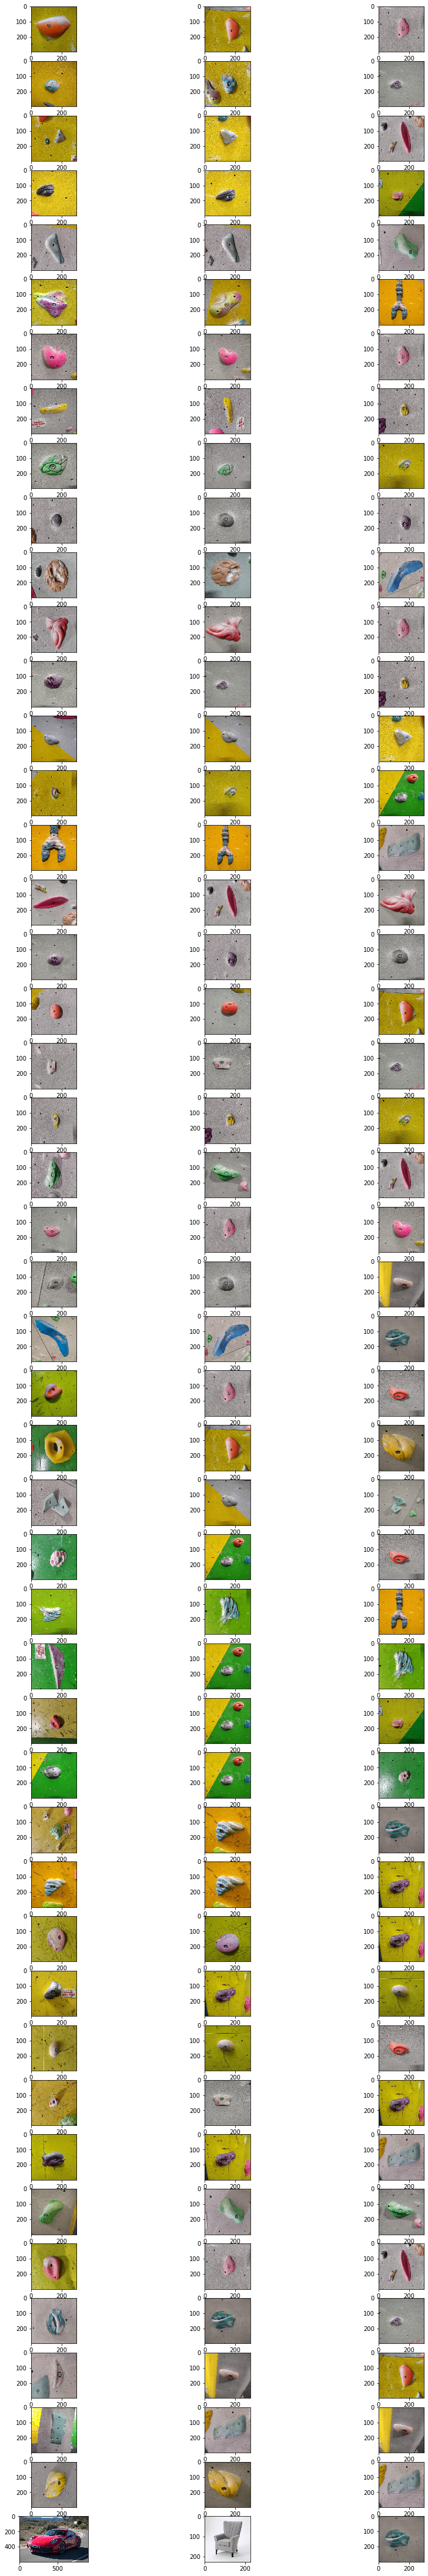

In [37]:
plot_results(list_of_cats)

#### Probability thresholds

In [0]:
import pandas as pd

In [0]:
def preds_table(model, validation_generator, list_of_cats):
  preds = get_probs(model, validation_generator)

  data = {'class': [],
        'first_cat': [],
        'first_prob': [],
        'second_cat': [],
        'second_prob': [],
        'third_cat': [],
        'third_prob': []
        }
  for c in sorted(list_of_cats, key=int):
    data['class'].append(c)
    for i in ['first', 'second', 'third']:
      data[f'{i}_cat'].append(get_pred(c, i, preds, 'index'))
      data[f'{i}_prob'].append(round(get_pred(c, i, preds, 'prob'), 4))
  for photo in range(10):
    data['class'].append(f'47_{photo}')
        for i in ['first', 'second', 'third']:
          data[f'{i}_cat'].append(get_pred('47', i, preds, 'index'))
          data[f'{i}_prob'].append(round(get_pred(c, i, preds, 'prob'), 4))


  data = pd.DataFrame.from_dict(data)
  data['correct'] = data['class'] == data.first_cat
  data = data.set_index('class')
  return data

In [0]:
data = preds_table(model, validation_generator, list_of_cats)

In [32]:
data

first_cat  first_prob second_cat  ...  third_cat third_prob  correct
class                                   ...                               
1             1      1.0000         23  ...          6     0.0000     True
2             2      0.9999         13  ...         38     0.0000     True
3             3      1.0000         17  ...         14     0.0000     True
4             4      1.0000         32  ...         40     0.0000     True
5             5      0.9783         41  ...         10     0.0059     True
6             6      1.0000         16  ...         43     0.0000     True
7             7      1.0000         23  ...         19     0.0000     True
8             8      1.0000         21  ...          5     0.0000     True
9             9      1.0000         15  ...         41     0.0000     True
10           10      1.0000         18  ...         36     0.0000     True
11           11      1.0000         25  ...         38     0.0000     True
12           12      1.0000         23  ...         17     0.0000     True
13           13      0.9911         21  ...         18     0.0000     True
14           14      1.0000          3  ...          6     0.0000     True
15           15      1.0000         33  ...         27     0.0000     True
16           16      1.0000         45  ...          6     0.0000     True
17           17      1.0000         12  ...         22     0.0000     True
18           18      1.0000         10  ...         14     0.0000     True
19           19      1.0000          1  ...          7     0.0000     True
20           20      0.9974         13  ...         26     0.0008     True
21           21      1.0000         15  ...         26     0.0000     True
22           22      1.0000         17  ...         38     0.0000     True
23           23      1.0000          7  ...         18     0.0000     True
24           10      0.9101         44  ...         13     0.0102    False
25           25      1.0000         43  ...         45     0.0000     True
26           23      1.0000         26  ...         19     0.0000    False
27            1      0.9999         46  ...          3     0.0000    False
28           14      0.8133         28  ...         25     0.0204    False
29           33      0.9999         26  ...         29     0.0000    False
30           30      0.9988         16  ...         33     0.0000     True
31           33      0.9592         30  ...         31     0.0170    False
32           33      1.0000         32  ...         45     0.0000    False
33           33      1.0000         29  ...         36     0.0000     True
34           35      0.9856         43  ...         30     0.0005    False
35           35      1.0000         40  ...         29     0.0000     True
36           36      1.0000         40  ...         29     0.0000     True
37           40      0.9993         38  ...         43     0.0000    False
38           38      0.9426         26  ...         40     0.0028     True
39           20      0.4982         40  ...         38     0.0322    False
40           40      1.0000         45  ...         14     0.0000     True
41           41      0.8912         22  ...          9     0.0000     True
42           23      0.6904         17  ...          1     0.0025    False
43           43      1.0000         13  ...         12     0.0000     True
44           44      1.0000          1  ...         45     0.0000     True
45           45      1.0000         44  ...         25     0.0000     True
46           46      1.0000         45  ...         18     0.0000     True
47           47      1.0000         43  ...         28     0.0000     True

[47 rows x 7 columns]

To do:

- Consider not just the first photo, but all
- Min and max for Correct and Incorrect predictions
- Try feeding a photo of not a hold
- Add data from your spreadsheet

Completely white - 0.2 was highest - predicted white hold. 

Chair 0.999 ... :( and the right category??

Ondra 0.97 - category 30 which had some blue colour

Just red 0.26